# SOC Prediction from Electrochemical Impedance Spectroscopy (EIS)

This notebook implements two experiments for predicting State of Charge (SOC) from Electrochemical Impedance Spectroscopy (EIS) data:

1. **Experiment 1**: Input the real and imaginary impedance values at all frequencies to predict SOC
2. **Experiment 2**: Input the real and imaginary impedance values along with the frequency to predict SOC

For each experiment, we train and evaluate:
- Classification models (predicting SOC as discrete classes)
- Regression models (predicting SOC as continuous values)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, max_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, multilabel_confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay

# Classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Regression models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

# TensorFlow for neural networks
import tensorflow as tf
import tf_keras as keras
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Dropout, Input
from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping
from tf_keras.regularizers import l2

!pip install -q -U tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
# Set random seeds for reproducibility
keras.utils.set_random_seed(42)

## 1. Data Loading and Preprocessing

In [2]:
# Load data files
frequencies_df = pd.read_csv('/kaggle/input/battery-eis/frequencies.csv')
impedance_df = pd.read_csv('/kaggle/input/battery-eis/impedance.csv')

print("Frequencies Dataset:")
print(frequencies_df.head())
print(f"\nTotal frequency points: {len(frequencies_df)}")

print("\nImpedance Dataset:")
print(impedance_df.head())
print(f"\nImpedance dataset shape: {impedance_df.shape}")
print(f"Unique SOC values: {impedance_df['SOC'].unique()}")
print(f"Unique batteries: {impedance_df['BATTERY_ID'].unique()}")

Frequencies Dataset:
   FREQUENCY_ID  FREQUENCY_VALUE
0             0             0.05
1             1             0.10
2             2             0.20
3             3             0.40
4             4             1.00

Total frequency points: 14

Impedance Dataset:
  MEASURE_ID  SOC  BATTERY_ID  FREQUENCY_ID  \
0       02_4  100           2             0   
1       02_4   90           2             0   
2       02_4   80           2             0   
3       02_4   70           2             0   
4       02_4   60           2             0   

                            IMPEDANCE_VALUE  
0  (0.110973570048518-0.00547305228273139j)  
1   (0.10776687163617-0.00597670185700764j)  
2   (0.107165211026746-0.0063320957096541j)  
3  (0.106558961363241-0.00648856565733705j)  
4  (0.106086309875063-0.00559046370050435j)  

Impedance dataset shape: (3360, 5)
Unique SOC values: [100  90  80  70  60  50  40  30  20  10]
Unique batteries: [2 3 5 6]


In [3]:
# Function to convert complex impedance strings to real and imaginary components
def split_complex(impedance_str):
    try:
        complex_num = complex(impedance_str)
        return complex_num.real, complex_num.imag
    except (ValueError, AttributeError):
        # Handle cases where the string is not in the expected format or is missing
        return np.nan, np.nan

# Extract real and imaginary parts of impedance
impedance_df[['real', 'imag']] = impedance_df['IMPEDANCE_VALUE'].apply(lambda x: pd.Series(split_complex(x)))

print("Processed impedance data with real and imaginary components:")
print(impedance_df.head())

Processed impedance data with real and imaginary components:
  MEASURE_ID  SOC  BATTERY_ID  FREQUENCY_ID  \
0       02_4  100           2             0   
1       02_4   90           2             0   
2       02_4   80           2             0   
3       02_4   70           2             0   
4       02_4   60           2             0   

                            IMPEDANCE_VALUE      real      imag  
0  (0.110973570048518-0.00547305228273139j)  0.110974 -0.005473  
1   (0.10776687163617-0.00597670185700764j)  0.107767 -0.005977  
2   (0.107165211026746-0.0063320957096541j)  0.107165 -0.006332  
3  (0.106558961363241-0.00648856565733705j)  0.106559 -0.006489  
4  (0.106086309875063-0.00559046370050435j)  0.106086 -0.005590  


In [4]:
# Merge with frequency values
impedance_df = pd.merge(impedance_df, frequencies_df, on='FREQUENCY_ID', how='left')
print("Data after merging with frequency values:")
print(impedance_df.head())

Data after merging with frequency values:
  MEASURE_ID  SOC  BATTERY_ID  FREQUENCY_ID  \
0       02_4  100           2             0   
1       02_4   90           2             0   
2       02_4   80           2             0   
3       02_4   70           2             0   
4       02_4   60           2             0   

                            IMPEDANCE_VALUE      real      imag  \
0  (0.110973570048518-0.00547305228273139j)  0.110974 -0.005473   
1   (0.10776687163617-0.00597670185700764j)  0.107767 -0.005977   
2   (0.107165211026746-0.0063320957096541j)  0.107165 -0.006332   
3  (0.106558961363241-0.00648856565733705j)  0.106559 -0.006489   
4  (0.106086309875063-0.00559046370050435j)  0.106086 -0.005590   

   FREQUENCY_VALUE  
0             0.05  
1             0.05  
2             0.05  
3             0.05  
4             0.05  


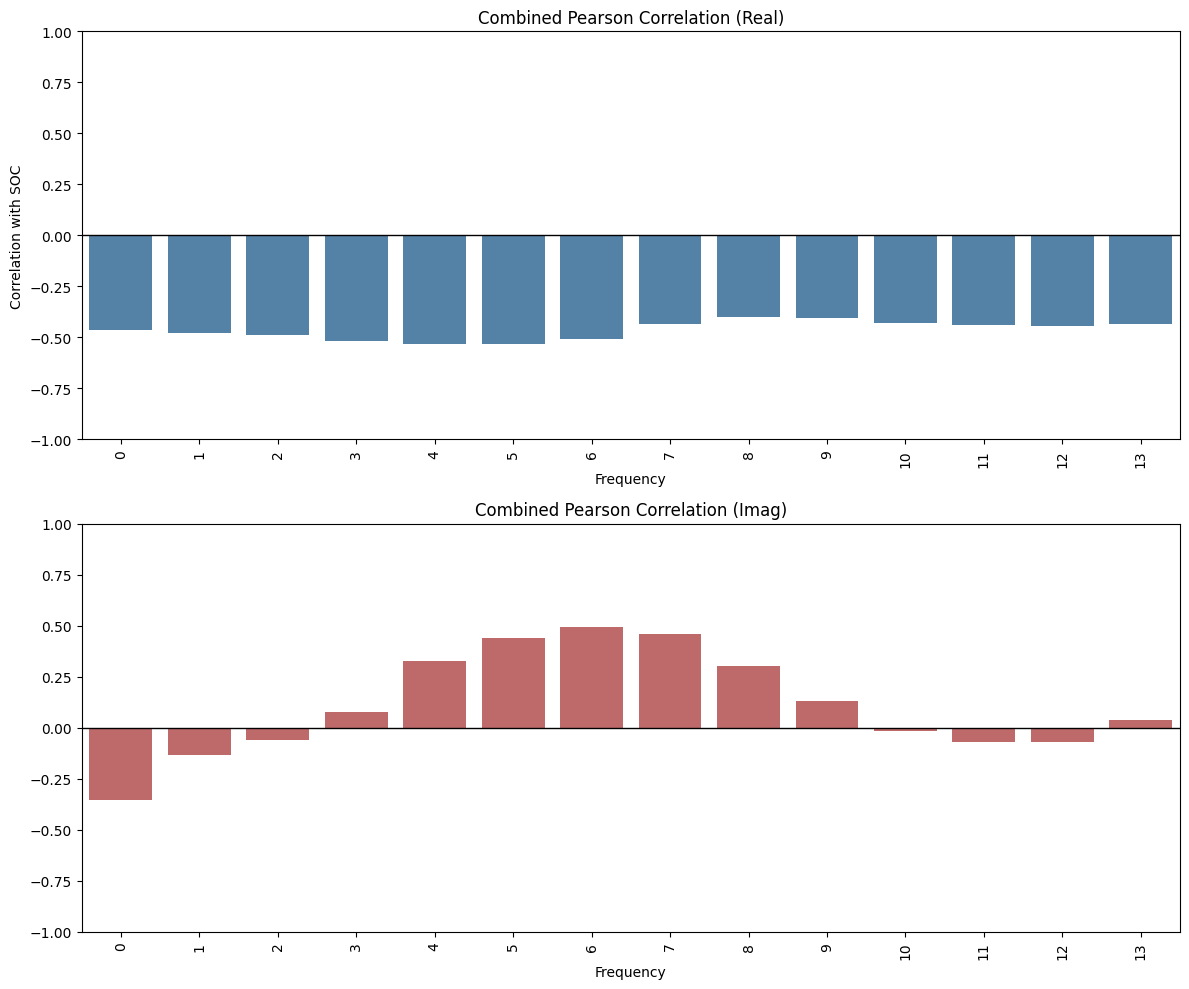

In [5]:
pivot_table_real = impedance_df.pivot_table(
    index=['MEASURE_ID', 'BATTERY_ID', 'SOC'],
    columns='FREQUENCY_ID',
    values='real'
)
pivot_table_real = pivot_table_real.reset_index()
pivot_table_real = pivot_table_real.drop(columns=['MEASURE_ID', 'BATTERY_ID'])

pivot_table_imag = impedance_df.pivot_table(
    index=['MEASURE_ID', 'BATTERY_ID', 'SOC'],
    columns='FREQUENCY_ID',
    values='imag'
)
pivot_table_imag = pivot_table_imag.reset_index()
pivot_table_imag = pivot_table_imag.drop(columns=['MEASURE_ID', 'BATTERY_ID'])

# Plot Pearson correlation for real and imaginary components
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Real component
real_corr = (
    pivot_table_real.drop(columns='SOC')
    .corrwith(pivot_table_real['SOC'])
    .dropna()
    .rename('correlation')
    .reset_index()
    .rename(columns={'index': 'FREQUENCY_ID'})
)
real_corr['FREQUENCY_ID'] = pd.to_numeric(real_corr['FREQUENCY_ID'])
real_corr = real_corr.sort_values('FREQUENCY_ID')
sns.barplot(data=real_corr, x="FREQUENCY_ID", y="correlation", color="steelblue", ax=axes[0])
axes[0].set_title("Combined Pearson Correlation (Real)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Correlation with SOC")
axes[0].axhline(0, color="black", linewidth=1)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(-1, 1)

# Imag component
imag_corr = (
    pivot_table_imag.drop(columns='SOC')
    .corrwith(pivot_table_imag['SOC'])
    .dropna()
    .rename('correlation')
    .reset_index()
    .rename(columns={'index': 'FREQUENCY_ID'})
)
imag_corr['FREQUENCY_ID'] = pd.to_numeric(imag_corr['FREQUENCY_ID'])
imag_corr = imag_corr.sort_values('FREQUENCY_ID')
sns.barplot(data=imag_corr, x="FREQUENCY_ID", y="correlation", color="indianred", ax=axes[1])
axes[1].set_title("Combined Pearson Correlation (Imag)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(-1, 1)

plt.tight_layout()
plt.show()

### 1.1 Preprocessing for Experiment 1 (All frequencies as features)

In [6]:
# Pivot the impedance data to create features for each frequency point
def prepare_data_exp1(impedance_df):
    # Pivot table to get real and imaginary parts for each frequency as separate columns
    pivoted_impedance = impedance_df.pivot(index=['MEASURE_ID', 'BATTERY_ID', 'SOC'], 
                                         columns='FREQUENCY_ID', 
                                         values=['real', 'imag'])
    
    # Flatten the columns for easier access
    pivoted_impedance.columns = [f"{kind}_f{freq}" for kind, freq in pivoted_impedance.columns]

    # Reset the index to make MEASURE_ID, BATTERY_ID, and SOC regular columns
    pivoted_impedance = pivoted_impedance.reset_index()
    
    return pivoted_impedance

# Prepare data for Experiment 1
exp1_data = prepare_data_exp1(impedance_df)

print("Experiment 1 data shape:", exp1_data.shape)
print("\nSample of Experiment 1 data:")
print(exp1_data.head())

# Define features (X) and target (y) for Experiment 1
X_exp1 = exp1_data.drop(columns=['MEASURE_ID', 'BATTERY_ID', 'SOC'])
y_exp1 = exp1_data['SOC']

# Split data into training and testing sets for Experiment 1
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = train_test_split(
    X_exp1, y_exp1, test_size=0.2, random_state=42
)

# Standardize features
scaler_exp1 = StandardScaler()
X_train_exp1_scaled = scaler_exp1.fit_transform(X_train_exp1)
X_test_exp1_scaled = scaler_exp1.transform(X_test_exp1)

print(f"\nExperiment 1 training data shape: {X_train_exp1_scaled.shape}")
print(f"Experiment 1 testing data shape: {X_test_exp1_scaled.shape}")

Experiment 1 data shape: (240, 31)

Sample of Experiment 1 data:
  MEASURE_ID  BATTERY_ID  SOC   real_f0   real_f1   real_f2   real_f3  \
0       02_4           2   10  0.117933  0.115688  0.114258  0.113243   
1       02_4           2   20  0.108914  0.107390  0.106296  0.105806   
2       02_4           2   30  0.105084  0.103869  0.103098  0.102843   
3       02_4           2   40  0.104545  0.103324  0.102673  0.102103   
4       02_4           2   50  0.103768  0.102449  0.101666  0.101108   

    real_f4   real_f5   real_f6  ...   imag_f4   imag_f5   imag_f6   imag_f7  \
0  0.111026  0.109057  0.106340  ... -0.004652 -0.005699 -0.006653 -0.007526   
1  0.104751  0.103965  0.102727  ... -0.002257 -0.002888 -0.004009 -0.005825   
2  0.101968  0.101440  0.100473  ... -0.001720 -0.002340 -0.003114 -0.004741   
3  0.101310  0.100783  0.100185  ... -0.001838 -0.002343 -0.002937 -0.004520   
4  0.099993  0.099596  0.099106  ... -0.001833 -0.002300 -0.002856 -0.004247   

    imag_f8   i

### 1.2 Preprocessing for Experiment 2 (Impedance and frequency as features)

In [7]:
# For Experiment 2, we use individual measurements with frequency as a feature
def prepare_data_exp2(impedance_df):
    # Use the real, imaginary parts and frequency value as features
    features = ['SOC', 'FREQUENCY_VALUE', 'real', 'imag']
    return impedance_df[features].copy()

# Prepare data for Experiment 2
exp2_data = prepare_data_exp2(impedance_df)

print("Experiment 2 data shape:", exp2_data.shape)
print("\nSample of Experiment 2 data:")
print(exp2_data.head())

# Define features (X) and target (y) for Experiment 2
X_exp2 = exp2_data.drop(columns=['SOC'])
y_exp2 = exp2_data['SOC']

# Split data into training and testing sets for Experiment 2
X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2 = train_test_split(
    X_exp2, y_exp2, test_size=0.2, random_state=42
)

# Standardize features
scaler_exp2 = StandardScaler()
X_train_exp2_scaled = scaler_exp2.fit_transform(X_train_exp2)
X_test_exp2_scaled = scaler_exp2.transform(X_test_exp2)

print(f"\nExperiment 2 training data shape: {X_train_exp2_scaled.shape}")
print(f"Experiment 2 testing data shape: {X_test_exp2_scaled.shape}")

Experiment 2 data shape: (3360, 4)

Sample of Experiment 2 data:
   SOC  FREQUENCY_VALUE      real      imag
0  100             0.05  0.110974 -0.005473
1   90             0.05  0.107767 -0.005977
2   80             0.05  0.107165 -0.006332
3   70             0.05  0.106559 -0.006489
4   60             0.05  0.106086 -0.005590

Experiment 2 training data shape: (2688, 3)
Experiment 2 testing data shape: (672, 3)


## 2. Evaluation Metrics Functions

In [8]:
def evaluate_regression(y_true, y_pred):
    """Evaluate regression models with multiple metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    stddev = np.std(y_true - y_pred)
    max_err = max_error(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'StdDev': stddev,
        'Max Error': max_err
    }

def evaluate_classification(y_true, y_pred):
    """Evaluate classification models with multiple metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate specificity from multilabel confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    specificities = []
    for cm in mcm:
        tn, fp, _, _ = cm.ravel()  # Extract TN, FP
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    specificity = np.mean(specificities)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Specificity': specificity
    }

## 3. Experiment 1: Predicting SOC from All Frequencies

### 3.1 Regression Models (Experiment 1)

In [9]:
# Initialize dictionary to store regression results for Experiment 1
exp1_regression_results = {}

# Function to train and evaluate a regression model
def train_evaluate_regression(model_name, model, X_train, X_test, y_train, y_test, results_dict):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = evaluate_regression(y_test, y_pred)
    results_dict[model_name] = results
    print(f"{model_name} trained. Results: {results}")
    return results

In [10]:
# 1. Gaussian Process Regressor with optimized hyperparameters
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=3.2772), alpha=3.0, random_state=42)
train_evaluate_regression('GPR', gpr, X_train_exp1_scaled, X_test_exp1_scaled, 
                          y_train_exp1, y_test_exp1, exp1_regression_results)

Training GPR...
GPR trained. Results: {'MAE': 12.257405276876275, 'RMSE': 18.942084077227168, 'R²': 0.48422693203714495, 'StdDev': 18.490532343642222, 'Max Error': 64.96395909000826}


{'MAE': 12.257405276876275,
 'RMSE': 18.942084077227168,
 'R²': 0.48422693203714495,
 'StdDev': 18.490532343642222,
 'Max Error': 64.96395909000826}

In [11]:
# 2. Linear Regression with optimized hyperparameters
ridge = Ridge(alpha=0.0023, solver='lsqr', random_state=42)
train_evaluate_regression('LR', ridge, X_train_exp1_scaled, X_test_exp1_scaled, 
                          y_train_exp1, y_test_exp1, exp1_regression_results)


Training LR...
LR trained. Results: {'MAE': 8.661664139298646, 'RMSE': 11.509063566627148, 'R²': 0.8095929087894617, 'StdDev': 11.506839744640759, 'Max Error': 30.473665428335806}


{'MAE': 8.661664139298646,
 'RMSE': 11.509063566627148,
 'R²': 0.8095929087894617,
 'StdDev': 11.506839744640759,
 'Max Error': 30.473665428335806}

In [12]:
# 3. Support Vector Regression with optimized hyperparameters
svr = SVR(kernel='rbf', C=7.7298, gamma=0.2582, epsilon=0.9447)
train_evaluate_regression('SVM', svr, X_train_exp1_scaled, X_test_exp1_scaled, 
                          y_train_exp1, y_test_exp1, exp1_regression_results)

Training SVM...
SVM trained. Results: {'MAE': 11.880466095305083, 'RMSE': 18.846370602510568, 'R²': 0.4894261180558709, 'StdDev': 18.26005244920968, 'Max Error': 52.83365266280725}


{'MAE': 11.880466095305083,
 'RMSE': 18.846370602510568,
 'R²': 0.4894261180558709,
 'StdDev': 18.26005244920968,
 'Max Error': 52.83365266280725}

In [13]:
# 4. Kernel Ridge Regression with optimized hyperparameters
kr = KernelRidge(alpha=0.000005249, kernel='rbf', gamma=6.7342)
train_evaluate_regression('KR', kr, X_train_exp1_scaled, X_test_exp1_scaled, 
                          y_train_exp1, y_test_exp1, exp1_regression_results)

Training KR...
KR trained. Results: {'MAE': 57.43385136521123, 'RMSE': 63.204757932390315, 'R²': -4.742522238503181, 'StdDev': 26.385491139087783, 'Max Error': 100.0}


{'MAE': 57.43385136521123,
 'RMSE': 63.204757932390315,
 'R²': -4.742522238503181,
 'StdDev': 26.385491139087783,
 'Max Error': 100.0}

In [14]:
# 5. Random Forest Regressor with optimized hyperparameters
rf = RandomForestRegressor(n_estimators=486, min_samples_leaf=1, 
                          bootstrap=True, random_state=42)
train_evaluate_regression('RF', rf, X_train_exp1_scaled, X_test_exp1_scaled, 
                          y_train_exp1, y_test_exp1, exp1_regression_results)

Training RF...
RF trained. Results: {'MAE': 4.95670438957476, 'RMSE': 7.563484277720425, 'R²': 0.9177668440590699, 'StdDev': 7.5634329536290625, 'Max Error': 29.238683127572017}


{'MAE': 4.95670438957476,
 'RMSE': 7.563484277720425,
 'R²': 0.9177668440590699,
 'StdDev': 7.5634329536290625,
 'Max Error': 29.238683127572017}

### 3.2 Neural Network for Regression (Experiment 1)

In [15]:
# Define Neural Network for regression using TensorFlow
def create_nn_regressor(input_dim, layers, lambda_reg):
    model = Sequential()
    model.add(Input(shape=(input_dim, )))
    for i in range(len(layers)):
        model.add(Dense(layers[i], activation='sigmoid', kernel_regularizer=l2(lambda_reg)))

    model.add(Dense(1))  # Output layer for regression
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse'
    )
    
    return model

# Train neural network for Experiment 1 regression
input_dim_exp1 = X_train_exp1_scaled.shape[1]
nn_reg_exp1 = create_nn_regressor(input_dim_exp1, [298, 275], 0.0014)

print("Training Neural Network for Regression (Experiment 1)...")
history_reg_exp1 = nn_reg_exp1.fit(
    X_train_exp1_scaled, y_train_exp1,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate neural network on test data
y_pred_nn_reg_exp1 = nn_reg_exp1.predict(X_test_exp1_scaled).flatten()
nn_reg_exp1_results = evaluate_regression(y_test_exp1, y_pred_nn_reg_exp1)
exp1_regression_results['ANN'] = nn_reg_exp1_results
print(f"Neural Network (Experiment 1) regression results: {nn_reg_exp1_results}")

Training Neural Network for Regression (Experiment 1)...
Epoch 1/300
5/5 [==============================] - 1s 50ms/step - loss: 3602.4844 - val_loss: 3602.6001
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 3205.3035 - val_loss: 3280.5649
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 2935.8469 - val_loss: 3059.0388
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 2747.1924 - val_loss: 2913.8330
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 2618.1111 - val_loss: 2811.0212
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 2526.8203 - val_loss: 2727.7839
Epoch 7/300
5/5 [==============================] - 0s 10ms/step - loss: 2446.2065 - val_loss: 2655.4004
Epoch 8/300
5/5 [==============================] - 0s 10ms/step - loss: 2378.2969 - val_loss: 2587.4607
Epoch 9/300
5/5 [==============================] - 0s 10ms/step - loss: 2310.9656 - val_loss: 2523.0662
Epoch 1

### 3.3 Regression Results Visualization (Experiment 1)

           MAE       RMSE        R²     StdDev   Max Error
RF    4.956704   7.563484  0.917767   7.563433   29.238683
LR    8.661664  11.509064  0.809593  11.506840   30.473665
ANN   9.513871  12.288580  0.782927  12.118185   22.588959
SVM  11.880466  18.846371  0.489426  18.260052   52.833653
GPR  12.257405  18.942084  0.484227  18.490532   64.963959
KR   57.433851  63.204758 -4.742522  26.385491  100.000000


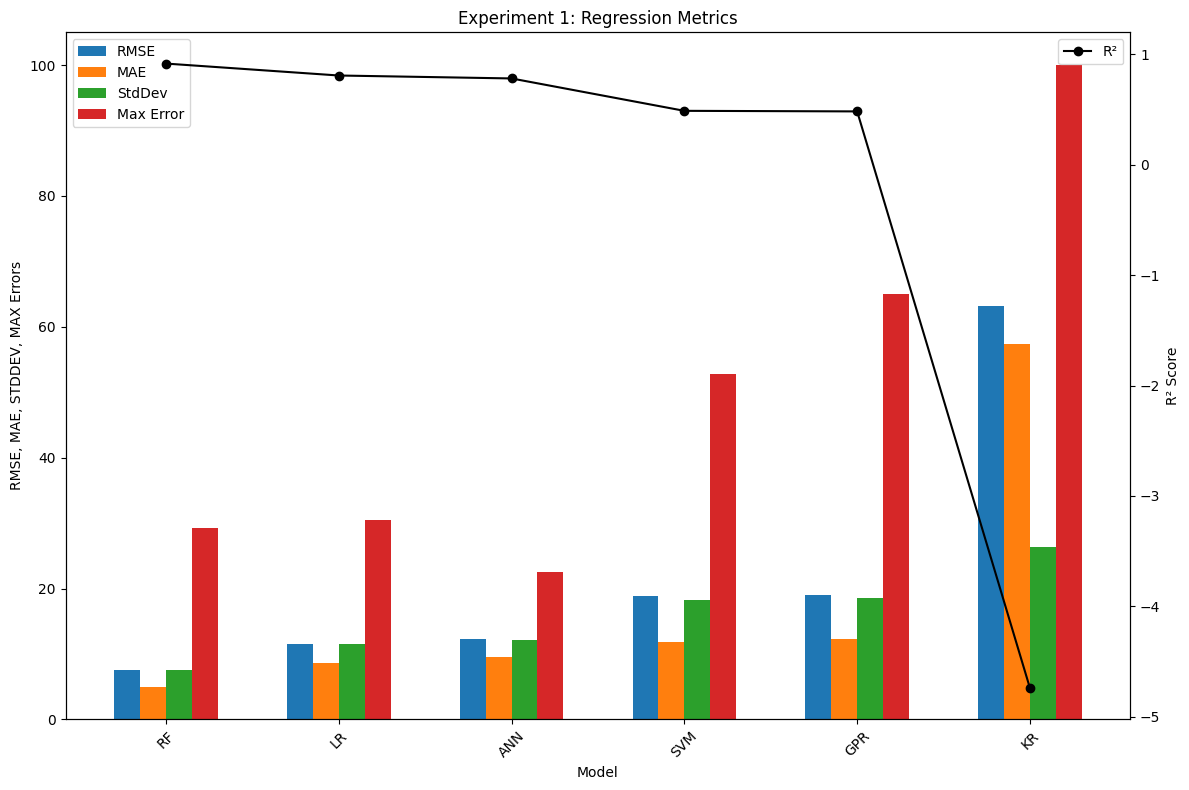

In [16]:
# Sort the DataFrame by R² score in descending order
results_df_exp1_reg = pd.DataFrame.from_dict(exp1_regression_results, orient='index')
results_df_exp1_reg_sorted = results_df_exp1_reg.sort_values(by='R²', ascending=False)

print(results_df_exp1_reg_sorted)

# Bar and line metrics
bar_metrics = ['RMSE', 'MAE', 'StdDev', 'Max Error']
line_metric = 'R²'

# Set up figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# X axis
models = results_df_exp1_reg_sorted.index
x = range(len(models))

# Bar plot on primary axis
bar_width = 0.15
for i, metric in enumerate(bar_metrics):
    ax1.bar([pos + i * bar_width for pos in x], results_df_exp1_reg_sorted[metric], 
            width=bar_width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE, MAE, STDDEV, MAX Errors')
ax1.set_xticks([pos + bar_width * 1.5 for pos in x])
ax1.set_xticklabels(models, rotation=45)
ax1.legend(loc='upper left')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot([pos + bar_width * 1.5 for pos in x], results_df_exp1_reg_sorted[line_metric],
         color='black', marker='o', label=line_metric)
ax2.set_ylabel('R² Score')
ax2.legend(loc='upper right')

plt.title('Experiment 1: Regression Metrics')
plt.tight_layout()
plt.show()

### 3.4 Classification Models (Experiment 1)

In [17]:
# For classification, we need to convert SOC values to class labels
# SOC values are already categorical (10, 20, 30, etc.)
y_train_class_exp1 = y_train_exp1
y_test_class_exp1 = y_test_exp1

print(f"Unique SOC classes in training data: {y_train_class_exp1.unique()}")
print(f"Unique SOC classes in test data: {y_test_class_exp1.unique()}")

Unique SOC classes in training data: [100  10  50  70  80  40  60  20  90  30]
Unique SOC classes in test data: [ 50  70  40 100  30  60  90  10  80  20]


In [18]:
# Initialize dictionary to store classification results for Experiment 1
exp1_classification_results = {}

# Function to train and evaluate a classification model
def train_evaluate_classification(model_name, model, X_train, X_test, y_train, y_test, results_dict):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = evaluate_classification(y_test, y_pred)
    results_dict[model_name] = results
    print(f"{model_name} trained. Results: {results}")
    return results

# 1. K-Nearest Neighbors Classifier with optimized hyperparameters
knn = KNeighborsClassifier(n_neighbors=1, metric='chebyshev')
train_evaluate_classification('KNN', knn, X_train_exp1_scaled, X_test_exp1_scaled, 
                            y_train_class_exp1, y_test_class_exp1, exp1_classification_results)

# 2. Quadratic Discriminant Analysis with optimized hyperparameters
qda = QuadraticDiscriminantAnalysis(reg_param=0.2576)
train_evaluate_classification('QDA', qda, X_train_exp1_scaled, X_test_exp1_scaled, 
                            y_train_class_exp1, y_test_class_exp1, exp1_classification_results)

# 3. Gaussian Naive Bayes with optimized hyperparameters
gnb = GaussianNB()
train_evaluate_classification('GNB', gnb, X_train_exp1_scaled, X_test_exp1_scaled, 
                            y_train_class_exp1, y_test_class_exp1, exp1_classification_results)

# 4. Support Vector Classifier with optimized hyperparameters
svc = SVC(kernel='rbf', C=0.0011, gamma=0.0196, decision_function_shape='ovo')
train_evaluate_classification('SVM', svc, X_train_exp1_scaled, X_test_exp1_scaled, 
                            y_train_class_exp1, y_test_class_exp1, exp1_classification_results)

# 5. Random forest Classifier with optimized hyperparameters
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3, min_samples_leaf=5), 
                         n_estimators=18, learning_rate=0.9665, random_state=42)
train_evaluate_classification('RF', ada, X_train_exp1_scaled, X_test_exp1_scaled, 
                            y_train_class_exp1, y_test_class_exp1, exp1_classification_results)

Training KNN...
KNN trained. Results: {'Accuracy': 0.5, 'Precision': 0.6, 'Recall': 0.5225, 'F1': 0.5373160173160174, 'Specificity': 0.944754241096506}
Training QDA...
QDA trained. Results: {'Accuracy': 0.4791666666666667, 'Precision': 0.5690977443609022, 'Recall': 0.6133333333333333, 'F1': 0.5263131313131313, 'Specificity': 0.9443388893995566}
Training GNB...
GNB trained. Results: {'Accuracy': 0.6875, 'Precision': 0.8002164502164503, 'Recall': 0.7086111111111111, 'F1': 0.7291267504425398, 'Specificity': 0.9646899224806201}
Training SVM...
SVM trained. Results: {'Accuracy': 0.041666666666666664, 'Precision': 0.004166666666666667, 'Recall': 0.1, 'F1': 0.007999999999999998, 'Specificity': 0.9}
Training RF...
RF trained. Results: {'Accuracy': 0.7708333333333334, 'Precision': 0.8071428571428573, 'Recall': 0.8188888888888888, 'F1': 0.789004329004329, 'Specificity': 0.9745661621268296}


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.7708333333333334,
 'Precision': 0.8071428571428573,
 'Recall': 0.8188888888888888,
 'F1': 0.789004329004329,
 'Specificity': 0.9745661621268296}

### 3.5 Neural Network for Classification (Experiment 1)

In [19]:
# Define Neural Network for classification using TensorFlow
def create_nn_classifier(input_dim, layers, num_classes, lambda_reg):
    model = Sequential()
    model.add(Input(shape=(input_dim, )))

    for i in range(len(layers)):
        model.add(Dense(layers[i], activation='sigmoid', kernel_regularizer=l2(lambda_reg)))

    model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Determine the number of classes
num_classes_exp1 = len(y_train_class_exp1.unique())

# We need to map the SOC values to integers from 0 to num_classes-1 for sparse_categorical_crossentropy
soc_to_class = {soc: i for i, soc in enumerate(sorted(y_train_class_exp1.unique()))}
class_to_soc = {i: soc for soc, i in soc_to_class.items()}

y_train_nn_class_exp1 = y_train_class_exp1.map(soc_to_class)
y_test_nn_class_exp1 = y_test_class_exp1.map(soc_to_class)

# Train neural network for Experiment 1 classification
nn_cls_exp1 = create_nn_classifier(input_dim_exp1, [295, 30], num_classes_exp1, 0.000073798)

print("Training Neural Network for Classification (Experiment 1)...")
history_cls_exp1 = nn_cls_exp1.fit(
    X_train_exp1_scaled, y_train_nn_class_exp1,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate neural network on test data
y_pred_nn_cls_exp1_probs = nn_cls_exp1.predict(X_test_exp1_scaled)
y_pred_nn_cls_exp1_classes = np.argmax(y_pred_nn_cls_exp1_probs, axis=1)
# Map predicted class indices back to SOC values
y_pred_nn_cls_exp1 = pd.Series(y_pred_nn_cls_exp1_classes).map(class_to_soc)

nn_cls_exp1_results = evaluate_classification(y_test_class_exp1, y_pred_nn_cls_exp1)
exp1_classification_results['ANN'] = nn_cls_exp1_results
print(f"Neural Network (Experiment 1) classification results: {nn_cls_exp1_results}")

Training Neural Network for Classification (Experiment 1)...
Epoch 1/300
10/10 [==============================] - 1s 23ms/step - loss: 2.3814 - accuracy: 0.0980 - val_loss: 2.2699 - val_accuracy: 0.1795
Epoch 2/300
10/10 [==============================] - 0s 5ms/step - loss: 2.2481 - accuracy: 0.1699 - val_loss: 2.2204 - val_accuracy: 0.2821
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 2.1883 - accuracy: 0.2288 - val_loss: 2.1733 - val_accuracy: 0.2308
Epoch 4/300
10/10 [==============================] - 0s 5ms/step - loss: 2.1283 - accuracy: 0.3268 - val_loss: 2.1219 - val_accuracy: 0.3590
Epoch 5/300
10/10 [==============================] - 0s 5ms/step - loss: 2.0788 - accuracy: 0.3725 - val_loss: 2.0739 - val_accuracy: 0.3846
Epoch 6/300
10/10 [==============================] - 0s 5ms/step - loss: 2.0450 - accuracy: 0.4118 - val_loss: 2.0208 - val_accuracy: 0.4103
Epoch 7/300
10/10 [==============================] - 0s 5ms/step - loss: 1.9915 - accuracy: 

### 3.6 Classification Results Visualization (Experiment 1)

Experiment 1 Classification Results:
     Accuracy  Precision    Recall        F1  Specificity
KNN  0.500000   0.600000  0.522500  0.537316     0.944754
QDA  0.479167   0.569098  0.613333  0.526313     0.944339
GNB  0.687500   0.800216  0.708611  0.729127     0.964690
SVM  0.041667   0.004167  0.100000  0.008000     0.900000
RF   0.770833   0.807143  0.818889  0.789004     0.974566
ANN  0.916667   0.933333  0.942500  0.923388     0.991008


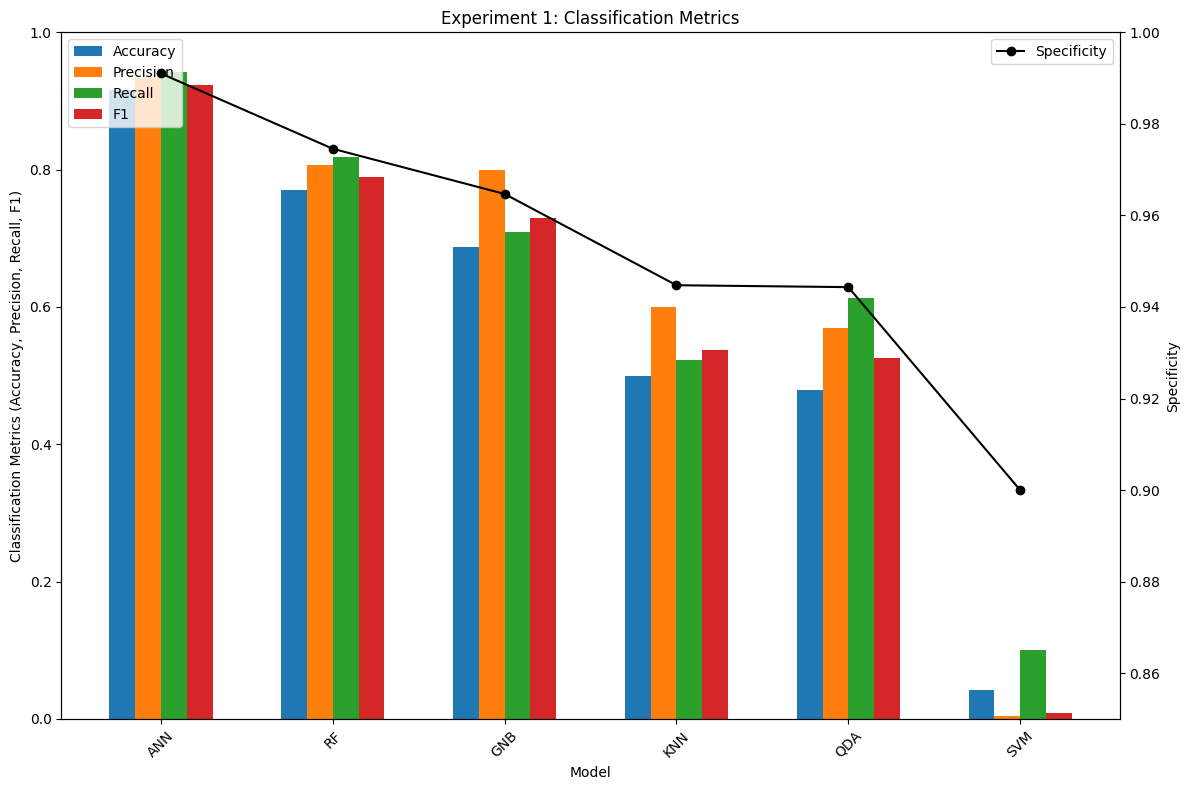

In [20]:
# Convert results to DataFrame
results_df_exp1_cls = pd.DataFrame.from_dict(exp1_classification_results, orient='index')
print("Experiment 1 Classification Results:")
print(results_df_exp1_cls)

# Sort by Specificity descending
results_df_exp1_cls_sorted = results_df_exp1_cls.sort_values(by='Specificity', ascending=False)

# Bar and line metrics
bar_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
line_metric = 'Specificity'

# Set up figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# X axis
models = results_df_exp1_cls_sorted.index
x = range(len(models))

# Bar plot on primary axis
bar_width = 0.15
for i, metric in enumerate(bar_metrics):
    ax1.bar([pos + i * bar_width for pos in x], results_df_exp1_cls_sorted[metric],
            width=bar_width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('Classification Metrics (Accuracy, Precision, Recall, F1)')
ax1.set_xticks([pos + bar_width * 1.5 for pos in x])
ax1.set_xticklabels(models, rotation=45)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot([pos + bar_width * 1.5 for pos in x], results_df_exp1_cls_sorted[line_metric],
         color='black', marker='o', label=line_metric)
ax2.set_ylabel('Specificity')
ax2.set_ylim(.85, 1)
ax2.legend(loc='upper right')

plt.title('Experiment 1: Classification Metrics')
plt.tight_layout()
plt.show()

## 4. Experiment 2: Predicting SOC from Individual Impedance and Frequency

### 4.1 Regression Models (Experiment 2)

In [21]:
# Initialize dictionary to store regression results for Experiment 2
exp2_regression_results = {}

# Train and evaluate regression models on Experiment 2 data with optimized hyperparameters

# 1. Gaussian Process Regressor with optimized hyperparameters
gpr_exp2 = GaussianProcessRegressor(kernel=RBF(length_scale=22.572), alpha=3.0, random_state=42)
train_evaluate_regression('GPR', gpr_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                          y_train_exp2, y_test_exp2, exp2_regression_results)

# 2. Linear Regression (LR in the table) with optimized hyperparameters
ridge_exp2 = Ridge(alpha=0.0024, solver='lsqr', random_state=42)
train_evaluate_regression('LR', ridge_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                          y_train_exp2, y_test_exp2, exp2_regression_results)

# 3. Support Vector Regression with optimized hyperparameters
svr_exp2 = SVR(kernel='rbf', C=186.9, gamma=56.177, epsilon=0.1187)
train_evaluate_regression('SVM', svr_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                          y_train_exp2, y_test_exp2, exp2_regression_results)

# 4. Kernel Ridge Regression with optimized hyperparameters
kr_exp2 = KernelRidge(alpha=0.00000256, kernel='rbf', gamma=0.62218)
train_evaluate_regression('KR', kr_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                          y_train_exp2, y_test_exp2, exp2_regression_results)

# 5. Random Forest Regressor with optimized hyperparameters
rf_exp2 = RandomForestRegressor(n_estimators=230, min_samples_leaf=1, 
                              bootstrap=True, random_state=42)
train_evaluate_regression('RF', rf_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                          y_train_exp2, y_test_exp2, exp2_regression_results)

Training GPR...
GPR trained. Results: {'MAE': 19.471319036489994, 'RMSE': 24.357992125088817, 'R²': 0.2803891772789965, 'StdDev': 24.292602483850786, 'Max Error': 81.65928621559578}
Training LR...
LR trained. Results: {'MAE': 23.8158236151288, 'RMSE': 27.43008834738604, 'R²': 0.08742382201671384, 'StdDev': 27.397889356745697, 'Max Error': 68.72865877555805}
Training SVM...
SVM trained. Results: {'MAE': 20.606737609075076, 'RMSE': 27.800984846215112, 'R²': 0.0625781395407271, 'StdDev': 27.54175443641553, 'Max Error': 99.43501984988345}
Training KR...
KR trained. Results: {'MAE': 17.97383559865522, 'RMSE': 22.846020296095492, 'R²': 0.3669531800715161, 'StdDev': 22.82189356237836, 'Max Error': 85.98791190981865}
Training RF...
RF trained. Results: {'MAE': 17.5254917184265, 'RMSE': 24.44557806679019, 'R²': 0.2752047508921499, 'StdDev': 24.435422095655085, 'Max Error': 86.26086956521739}


{'MAE': 17.5254917184265,
 'RMSE': 24.44557806679019,
 'R²': 0.2752047508921499,
 'StdDev': 24.435422095655085,
 'Max Error': 86.26086956521739}

### 4.2 Neural Network for Regression (Experiment 2)

In [22]:
# Train neural network for Experiment 2 regression
input_dim_exp2 = X_train_exp2_scaled.shape[1]
nn_reg_exp2 = create_nn_regressor(input_dim_exp2, [251, 267], 0.0093249)

print("Training Neural Network for Regression (Experiment 2)...")
history_reg_exp2 = nn_reg_exp2.fit(
    X_train_exp2_scaled, y_train_exp2,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate neural network on test data
y_pred_nn_reg_exp2 = nn_reg_exp2.predict(X_test_exp2_scaled).flatten()
nn_reg_exp2_results = evaluate_regression(y_test_exp2, y_pred_nn_reg_exp2)
exp2_regression_results['ANN'] = nn_reg_exp2_results
print(f"Neural Network (Experiment 2) regression results: {nn_reg_exp2_results}")

Training Neural Network for Regression (Experiment 2)...
Epoch 1/300
135/135 [==============================] - 1s 3ms/step - loss: 2252.7517 - val_loss: 1466.6956
Epoch 2/300
135/135 [==============================] - 0s 3ms/step - loss: 1188.6483 - val_loss: 950.0945
Epoch 3/300
135/135 [==============================] - 0s 3ms/step - loss: 881.0876 - val_loss: 847.9211
Epoch 4/300
135/135 [==============================] - 0s 2ms/step - loss: 828.4400 - val_loss: 843.1434
Epoch 5/300
135/135 [==============================] - 0s 3ms/step - loss: 824.8790 - val_loss: 844.1141
Epoch 6/300
135/135 [==============================] - 0s 3ms/step - loss: 821.6024 - val_loss: 837.9227
Epoch 7/300
135/135 [==============================] - 0s 2ms/step - loss: 809.8057 - val_loss: 816.7518
Epoch 8/300
135/135 [==============================] - 0s 2ms/step - loss: 794.4479 - val_loss: 806.0004
Epoch 9/300
135/135 [==============================] - 0s 3ms/step - loss: 784.1096 - val_loss: 794.

### 4.3 Regression Results Visualization (Experiment 2)

Experiment 2 Regression Results:
           MAE       RMSE        R²     StdDev  Max Error
GPR  19.471319  24.357992  0.280389  24.292602  81.659286
LR   23.815824  27.430088  0.087424  27.397889  68.728659
SVM  20.606738  27.800985  0.062578  27.541754  99.435020
KR   17.973836  22.846020  0.366953  22.821894  85.987912
RF   17.525492  24.445578  0.275205  24.435422  86.260870
ANN  20.708458  24.795741  0.254292  24.678553  78.367577


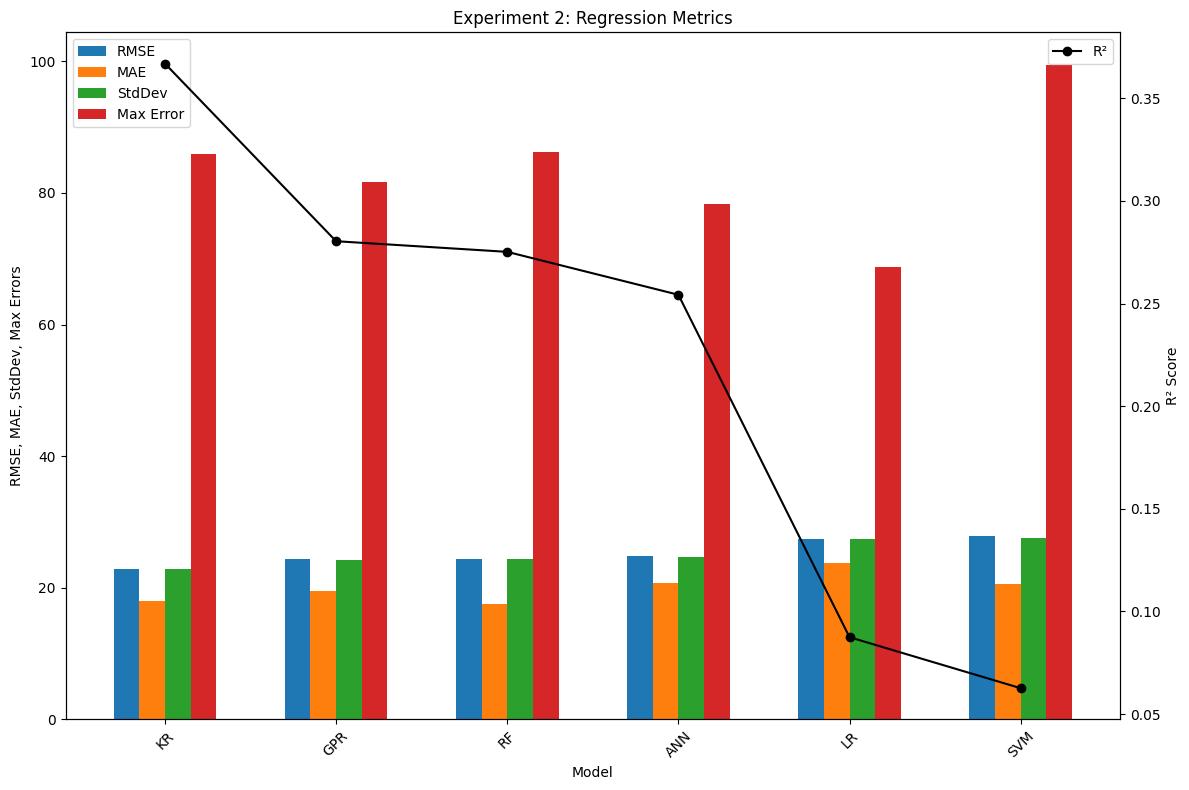

In [23]:
# Convert to DataFrame
results_df_exp2_reg = pd.DataFrame.from_dict(exp2_regression_results, orient='index')
print("Experiment 2 Regression Results:")
print(results_df_exp2_reg)

# Sort the DataFrame by R² score in descending order
results_df_exp2_reg_sorted = results_df_exp2_reg.sort_values(by='R²', ascending=False)

# Bar and line metrics
bar_metrics = ['RMSE', 'MAE', 'StdDev', 'Max Error']
line_metric = 'R²'

# Set up figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# X axis
models = results_df_exp2_reg_sorted.index
x = range(len(models))

# Bar plot on primary axis
bar_width = 0.15
for i, metric in enumerate(bar_metrics):
    ax1.bar([pos + i * bar_width for pos in x], results_df_exp2_reg_sorted[metric], 
            width=bar_width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE, MAE, StdDev, Max Errors')
ax1.set_xticks([pos + bar_width * 1.5 for pos in x])
ax1.set_xticklabels(models, rotation=45)
ax1.legend(loc='upper left')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot([pos + bar_width * 1.5 for pos in x], results_df_exp2_reg_sorted[line_metric],
         color='black', marker='o', label=line_metric)
ax2.set_ylabel('R² Score')
ax2.legend(loc='upper right')

plt.title('Experiment 2: Regression Metrics')
plt.tight_layout()
plt.show()

### 4.4 Classification Models (Experiment 2)

In [24]:
# For classification, we use the same SOC values
y_train_class_exp2 = y_train_exp2
y_test_class_exp2 = y_test_exp2

print(f"Unique SOC classes in training data (Experiment 2): {y_train_class_exp2.unique()}")
print(f"Unique SOC classes in test data (Experiment 2): {y_test_class_exp2.unique()}")

Unique SOC classes in training data (Experiment 2): [ 40  20  60  80  70 100  30  10  90  50]
Unique SOC classes in test data (Experiment 2): [ 60  80  50  30  40  70  20  90  10 100]


In [25]:
# Initialize dictionary to store classification results for Experiment 2
exp2_classification_results = {}

# Train and evaluate the same classification models on Experiment 2 data

# 1. K-Nearest Neighbors Classifier
knn_exp2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
train_evaluate_classification('KNN', knn_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                            y_train_class_exp2, y_test_class_exp2, exp2_classification_results)

# 2. Quadratic Discriminant Analysis
qda_exp2 = QuadraticDiscriminantAnalysis(reg_param=0.01)
train_evaluate_classification('QDA', qda_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                            y_train_class_exp2, y_test_class_exp2, exp2_classification_results)

# 3. Gaussian Naive Bayes
gnb_exp2 = GaussianNB()
train_evaluate_classification('GNB', gnb_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                            y_train_class_exp2, y_test_class_exp2, exp2_classification_results)

# 4. Support Vector Classifier
svc_exp2 = SVC(kernel='rbf', C=1.0, random_state=42)
train_evaluate_classification('SVM', svc_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                            y_train_class_exp2, y_test_class_exp2, exp2_classification_results)

# 5. Random Forest Classifier
rf_cls_exp2 = RandomForestClassifier(n_estimators=486, random_state=42)
train_evaluate_classification('RF', rf_cls_exp2, X_train_exp2_scaled, X_test_exp2_scaled, 
                            y_train_class_exp2, y_test_class_exp2, exp2_classification_results)

Training KNN...
KNN trained. Results: {'Accuracy': 0.31101190476190477, 'Precision': 0.3060523907743928, 'Recall': 0.31233912132350705, 'F1': 0.2924655347313732, 'Specificity': 0.9235775247566822}
Training QDA...
QDA trained. Results: {'Accuracy': 0.18601190476190477, 'Precision': 0.11432337298402873, 'Recall': 0.19356102086524063, 'F1': 0.13571956093553653, 'Specificity': 0.9101200446418363}
Training GNB...
GNB trained. Results: {'Accuracy': 0.17261904761904762, 'Precision': 0.1257127287975779, 'Recall': 0.17694746429643926, 'F1': 0.12639573893575135, 'Specificity': 0.9081738358107734}
Training SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM trained. Results: {'Accuracy': 0.23363095238095238, 'Precision': 0.24165764433150758, 'Recall': 0.23811925011238294, 'F1': 0.1983337581148582, 'Specificity': 0.9150819834784031}
Training RF...
RF trained. Results: {'Accuracy': 0.36607142857142855, 'Precision': 0.3605507674216095, 'Recall': 0.3676281372932515, 'F1': 0.3615171276291739, 'Specificity': 0.9295987692299782}


{'Accuracy': 0.36607142857142855,
 'Precision': 0.3605507674216095,
 'Recall': 0.3676281372932515,
 'F1': 0.3615171276291739,
 'Specificity': 0.9295987692299782}

### 4.5 Neural Network for Classification (Experiment 2)

In [26]:
# Determine the number of classes for Experiment 2
num_classes_exp2 = len(y_train_class_exp2.unique())

# We need to map the SOC values to integers from 0 to num_classes-1 for sparse_categorical_crossentropy
soc_to_class_exp2 = {soc: i for i, soc in enumerate(sorted(y_train_class_exp2.unique()))}
class_to_soc_exp2 = {i: soc for soc, i in soc_to_class_exp2.items()}

y_train_nn_class_exp2 = y_train_class_exp2.map(soc_to_class_exp2)
y_test_nn_class_exp2 = y_test_class_exp2.map(soc_to_class_exp2)

# Train neural network for Experiment 2 classification
nn_cls_exp2 = create_nn_classifier(input_dim_exp2, [25, 268], num_classes_exp2, 4.04e-09)

print("Training Neural Network for Classification (Experiment 2)...")
history_cls_exp2 = nn_cls_exp2.fit(
    X_train_exp2_scaled, y_train_nn_class_exp2,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate neural network on test data
y_pred_nn_cls_exp2_probs = nn_cls_exp2.predict(X_test_exp2_scaled)
y_pred_nn_cls_exp2_classes = np.argmax(y_pred_nn_cls_exp2_probs, axis=1)
# Map predicted class indices back to SOC values
y_pred_nn_cls_exp2 = pd.Series(y_pred_nn_cls_exp2_classes).map(class_to_soc_exp2)

nn_cls_exp2_results = evaluate_classification(y_test_class_exp2, y_pred_nn_cls_exp2)
exp2_classification_results['ANN'] = nn_cls_exp2_results
print(f"Neural Network (Experiment 2) classification results: {nn_cls_exp2_results}")

Training Neural Network for Classification (Experiment 2)...
Epoch 1/300
135/135 [==============================] - 1s 3ms/step - loss: 2.3206 - accuracy: 0.1149 - val_loss: 2.3184 - val_accuracy: 0.0967
Epoch 2/300
135/135 [==============================] - 0s 2ms/step - loss: 2.3130 - accuracy: 0.1223 - val_loss: 2.3090 - val_accuracy: 0.1115
Epoch 3/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2721 - accuracy: 0.1553 - val_loss: 2.2511 - val_accuracy: 0.1654
Epoch 4/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2466 - accuracy: 0.1600 - val_loss: 2.2269 - val_accuracy: 0.1431
Epoch 5/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2159 - accuracy: 0.1781 - val_loss: 2.1719 - val_accuracy: 0.1933
Epoch 6/300
135/135 [==============================] - 0s 2ms/step - loss: 2.1979 - accuracy: 0.1684 - val_loss: 2.1547 - val_accuracy: 0.2156
Epoch 7/300
135/135 [==============================] - 0s 2ms/step - loss: 2.1847

### 4.6 Classification Results Visualization (Experiment 2)

Experiment 2 Classification Results:
     Accuracy  Precision    Recall        F1  Specificity
KNN  0.311012   0.306052  0.312339  0.292466     0.923578
QDA  0.186012   0.114323  0.193561  0.135720     0.910120
GNB  0.172619   0.125713  0.176947  0.126396     0.908174
SVM  0.233631   0.241658  0.238119  0.198334     0.915082
RF   0.366071   0.360551  0.367628  0.361517     0.929599
ANN  0.261905   0.263202  0.265028  0.246611     0.918265


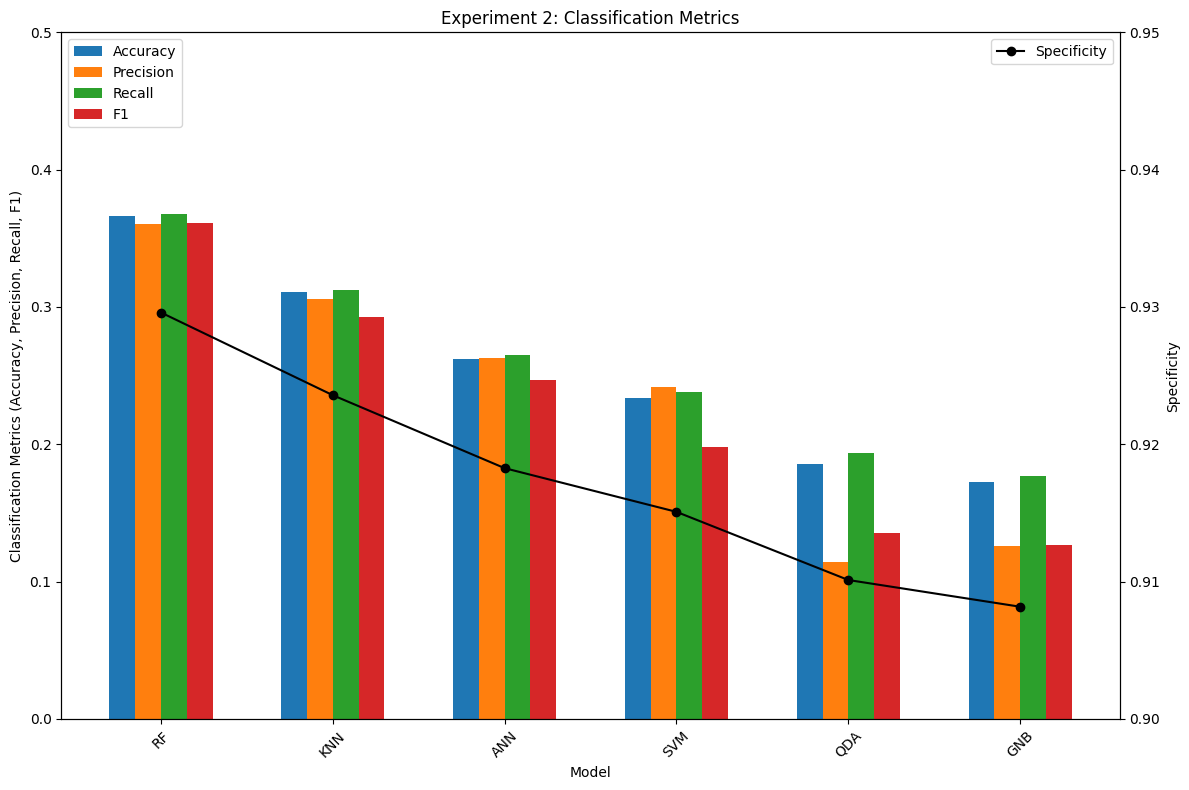

In [27]:
# Convert results to DataFrame
results_df_exp2_cls = pd.DataFrame.from_dict(exp2_classification_results, orient='index')
print("Experiment 2 Classification Results:")
print(results_df_exp2_cls)

# Sort by Specificity descending
results_df_exp2_cls_sorted = results_df_exp2_cls.sort_values(by='Specificity', ascending=False)

# Bar and line metrics
bar_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
line_metric = 'Specificity'

# Set up figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# X axis
models = results_df_exp2_cls_sorted.index
x = range(len(models))

# Bar plot on primary axis
bar_width = 0.15
for i, metric in enumerate(bar_metrics):
    ax1.bar([pos + i * bar_width for pos in x], results_df_exp2_cls_sorted[metric],
            width=bar_width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('Classification Metrics (Accuracy, Precision, Recall, F1)')
ax1.set_xticks([pos + bar_width * 1.5 for pos in x])
ax1.set_xticklabels(models, rotation=45)
ax1.set_ylim(0, .5)
ax1.legend(loc='upper left')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot([pos + bar_width * 1.5 for pos in x], results_df_exp2_cls_sorted[line_metric],
         color='black', marker='o', label=line_metric)
ax2.set_ylabel('Specificity')
ax2.set_ylim(.9, .95)
ax2.legend(loc='upper right')

plt.title('Experiment 2: Classification Metrics')
plt.tight_layout()
plt.show()

## 5. Comparing Experiments 1 and 2

In [28]:
# Compare the best models from both experiments
def get_best_model(results_dict, metric, higher_is_better=True):
    """Find the best model based on a specific metric"""
    if higher_is_better:
        best_model = max(results_dict.items(), key=lambda x: x[1][metric])
    else:
        best_model = min(results_dict.items(), key=lambda x: x[1][metric])
    return best_model[0], best_model[1][metric]

# For regression, lower MAE and RMSE are better, higher R² is better
print("Best Regression Models:")
print("\nExperiment 1 (All frequencies as features):")
best_mae_exp1_model, best_mae_exp1 = get_best_model(exp1_regression_results, 'MAE', False)
best_rmse_exp1_model, best_rmse_exp1 = get_best_model(exp1_regression_results, 'RMSE', False)
best_r2_exp1_model, best_r2_exp1 = get_best_model(exp1_regression_results, 'R²', True)
print(f"Best MAE: {best_mae_exp1_model} ({best_mae_exp1:.3f})")
print(f"Best RMSE: {best_rmse_exp1_model} ({best_rmse_exp1:.3f})")
print(f"Best R²: {best_r2_exp1_model} ({best_r2_exp1:.3f})")

print("\nExperiment 2 (Impedance and frequency as features):")
best_mae_exp2_model, best_mae_exp2 = get_best_model(exp2_regression_results, 'MAE', False)
best_rmse_exp2_model, best_rmse_exp2 = get_best_model(exp2_regression_results, 'RMSE', False)
best_r2_exp2_model, best_r2_exp2 = get_best_model(exp2_regression_results, 'R²', True)
print(f"Best MAE: {best_mae_exp2_model} ({best_mae_exp2:.3f})")
print(f"Best RMSE: {best_rmse_exp2_model} ({best_rmse_exp2:.3f})")
print(f"Best R²: {best_r2_exp2_model} ({best_r2_exp2:.3f})")

# For classification, higher accuracy, precision, recall, F1, and specificity are better
print("\n\nBest Classification Models:")
print("\nExperiment 1 (All frequencies as features):")
best_acc_exp1_model, best_acc_exp1 = get_best_model(exp1_classification_results, 'Accuracy', True)
best_f1_exp1_model, best_f1_exp1 = get_best_model(exp1_classification_results, 'F1', True)
print(f"Best Accuracy: {best_acc_exp1_model} ({best_acc_exp1:.3f})")
print(f"Best F1 Score: {best_f1_exp1_model} ({best_f1_exp1:.3f})")

print("\nExperiment 2 (Impedance and frequency as features):")
best_acc_exp2_model, best_acc_exp2 = get_best_model(exp2_classification_results, 'Accuracy', True)
best_f1_exp2_model, best_f1_exp2 = get_best_model(exp2_classification_results, 'F1', True)
print(f"Best Accuracy: {best_acc_exp2_model} ({best_acc_exp2:.3f})")
print(f"Best F1 Score: {best_f1_exp2_model} ({best_f1_exp2:.3f})")

Best Regression Models:

Experiment 1 (All frequencies as features):
Best MAE: RF (4.957)
Best RMSE: RF (7.563)
Best R²: RF (0.918)

Experiment 2 (Impedance and frequency as features):
Best MAE: RF (17.525)
Best RMSE: KR (22.846)
Best R²: KR (0.367)


Best Classification Models:

Experiment 1 (All frequencies as features):
Best Accuracy: ANN (0.917)
Best F1 Score: ANN (0.923)

Experiment 2 (Impedance and frequency as features):
Best Accuracy: RF (0.366)
Best F1 Score: RF (0.362)


## Summary of NN in experiment 1

In [29]:
print(nn_cls_exp1.summary())
print(nn_reg_exp1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 295)               8555      
                                                                 
 dense_4 (Dense)             (None, 30)                8880      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 17745 (69.32 KB)
Trainable params: 17745 (69.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 298)               8642      
                                                           

In [30]:
# Pruning and quantization
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

def apply_pruning_quantization(model, X_train, y_train, task, epochs=10, batch_size=32, lr=1e-3):
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.5,
            final_sparsity=0.8,
            begin_step=0,
            end_step=np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs
        )
    }
    pruned = prune_low_magnitude(model, **pruning_params)
    loss = 'sparse_categorical_crossentropy' if task == 'cls' else 'mse'
    metrics = ['accuracy'] if task == 'cls' else []
    pruned.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)
    pruned.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=[tfmot.sparsity.keras.UpdatePruningStep()]
    )
    stripped = tfmot.sparsity.keras.strip_pruning(pruned)

    # ptq
    converter = tf.lite.TFLiteConverter.from_keras_model(stripped)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    ptq = converter.convert()

    return ptq

In [31]:
# Apply pruning/quantization + evaluate and compare to baseline

# Classification
nn_cls_exp1_quantized_bytes = apply_pruning_quantization(
    nn_cls_exp1, X_train_exp1_scaled, y_train_nn_class_exp1, task='cls')
# Load the TFLite model and allocate tensors
nn_cls_exp1_quantized = tf.lite.Interpreter(model_content=nn_cls_exp1_quantized_bytes)
nn_cls_exp1_quantized.allocate_tensors()
# Get input and output tensors
input_details = nn_cls_exp1_quantized.get_input_details()
output_details = nn_cls_exp1_quantized.get_output_details()
# Predict model on testing set
X_test_exp1_scaled = X_test_exp1_scaled.astype("float32")
nn_cls_exp1_quantized.resize_tensor_input(input_details[0]['index'], X_test_exp1_scaled.shape)
nn_cls_exp1_quantized.allocate_tensors()
nn_cls_exp1_quantized.set_tensor(input_details[0]['index'], X_test_exp1_scaled)
nn_cls_exp1_quantized.invoke()
cls_probs_q = nn_cls_exp1_quantized.get_tensor(output_details[0]['index'])
cls_pred_idx_q = np.argmax(cls_probs_q, axis=1)
y_pred_nn_cls_exp1_quantized = pd.Series(cls_pred_idx_q).map(class_to_soc)
cls_baseline = evaluate_classification(y_test_class_exp1, y_pred_nn_cls_exp1)
cls_quant = evaluate_classification(y_test_class_exp1, y_pred_nn_cls_exp1_quantized)
print('Classification (Exp1) baseline:', cls_baseline)
print('Classification (Exp1) quantized:', cls_quant)

# Regression
nn_reg_exp1_quantized_bytes = apply_pruning_quantization(
    nn_reg_exp1, X_train_exp1_scaled, y_train_exp1, task='reg')
# Load the TFLite model and allocate tensors
nn_reg_exp1_quantized = tf.lite.Interpreter(model_content=nn_reg_exp1_quantized_bytes)
nn_reg_exp1_quantized.allocate_tensors()
# Get input and output tensors
input_details = nn_reg_exp1_quantized.get_input_details()
output_details = nn_reg_exp1_quantized.get_output_details()
# Predict model on testing set
X_test_exp1_scaled = X_test_exp1_scaled.astype("float32")
nn_reg_exp1_quantized.resize_tensor_input(input_details[0]['index'], X_test_exp1_scaled.shape)
nn_reg_exp1_quantized.allocate_tensors()
nn_reg_exp1_quantized.set_tensor(input_details[0]['index'], X_test_exp1_scaled)
nn_reg_exp1_quantized.invoke()
reg_pred_q = nn_reg_exp1_quantized.get_tensor(output_details[0]['index']).flatten()
reg_baseline = evaluate_regression(y_test_exp1, y_pred_nn_reg_exp1)
reg_quant = evaluate_regression(y_test_exp1, reg_pred_q)
print('Regression (Exp1) baseline:', reg_baseline)
print('Regression (Exp1) quantized:', reg_quant)

Epoch 1/10
5/5 [==============================] - 3s 59ms/step - loss: 0.1437 - accuracy: 0.9935 - val_loss: 0.2373 - val_accuracy: 0.9487
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1412 - accuracy: 0.9935 - val_loss: 0.2447 - val_accuracy: 0.9487
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1404 - accuracy: 0.9935 - val_loss: 0.2372 - val_accuracy: 0.9487
Epoch 4/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1393 - accuracy: 0.9935 - val_loss: 0.2459 - val_accuracy: 0.9487
Epoch 5/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1382 - accuracy: 0.9935 - val_loss: 0.2454 - val_accuracy: 0.9487
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1384 - accuracy: 0.9935 - val_loss: 0.2353 - val_accuracy: 0.9487
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1363 - accuracy: 0.9935 - val_loss: 0.2409 - val_accuracy: 0.9487
Epoch 8/10
5/5 [===========

<Figure size 1000x1000 with 0 Axes>

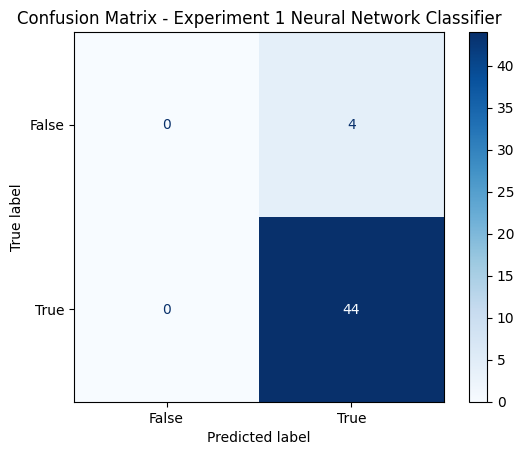

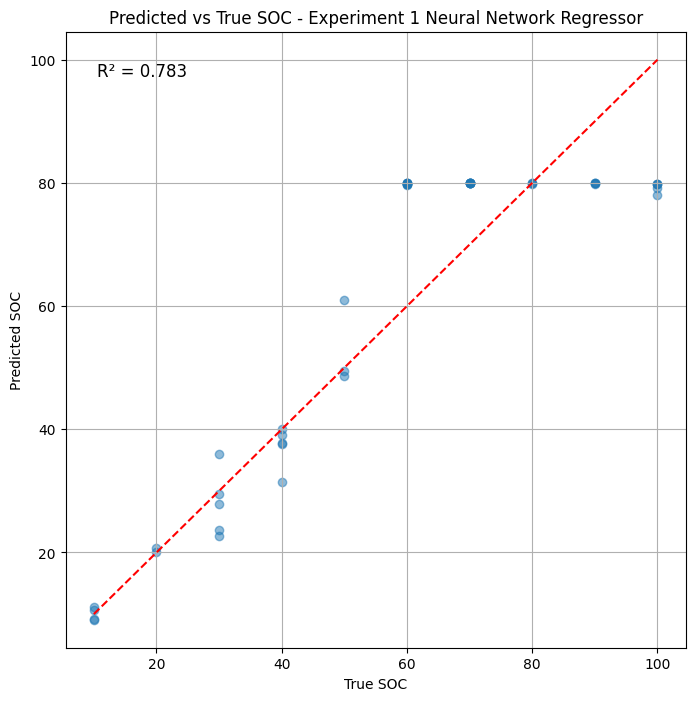

In [32]:
# Confusion matrix for classification
y_true_arr = np.array(y_test_class_exp1)
y_pred_arr = np.array(y_pred_nn_cls_exp1_quantized)
y_true_binary = (y_true_arr == y_pred_arr).astype(int)
y_pred_binary = np.ones_like(y_true_binary)
cm = confusion_matrix(y_true_binary, y_pred_binary)
# Overall confusion matrix, dont separate by class
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Experiment 1 Neural Network Classifier')
plt.show()

# Pred vs True scatter plot for regression
plt.figure(figsize=(8, 8))
plt.scatter(y_test_exp1, reg_pred_q, alpha=0.5)
plt.plot([y_test_exp1.min(), y_test_exp1.max()], [y_test_exp1.min(), y_test_exp1.max()], 'r--')
plt.xlabel('True SOC')
plt.ylabel('Predicted SOC')
plt.title('Predicted vs True SOC - Experiment 1 Neural Network Regressor')
# Add r2 score
r2 = r2_score(y_test_exp1, reg_pred_q)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.grid()
plt.show()

In [33]:
def to_tflite_bytes(keras_model, optim=None):
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    if optim:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    return converter.convert()

def bytes_to_kb(b):
    return len(b) / 1024

def report_sizes(name, float_bytes, quant_bytes):
    print(f"{name} float32 TFLite: {bytes_to_kb(float_bytes):.1f} KB")
    print(f"{name} quantized TFLite: {bytes_to_kb(quant_bytes):.1f} KB")
    if float_bytes:
        print(f"Reduction: {(1 - len(quant_bytes)/len(float_bytes))*100:.1f}%")

# Export and compare sizes for Exp1 NN classifier
cls_float_tflite = to_tflite_bytes(nn_cls_exp1)
cls_quant_tflite = nn_cls_exp1_quantized_bytes
report_sizes('Exp1 NN Classifier', cls_float_tflite, cls_quant_tflite)

# Export and compare sizes for Exp1 NN regressor
reg_float_tflite = to_tflite_bytes(nn_reg_exp1)
reg_quant_tflite = nn_reg_exp1_quantized_bytes
report_sizes('Exp1 NN Regressor', reg_float_tflite, reg_quant_tflite)

Exp1 NN Classifier float32 TFLite: 71.5 KB
Exp1 NN Classifier quantized TFLite: 25.3 KB
Reduction: 64.6%
Exp1 NN Regressor float32 TFLite: 358.1 KB
Exp1 NN Regressor quantized TFLite: 100.3 KB
Reduction: 72.0%
